In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import string
from nltk.corpus import stopwords
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.data import load
import re

import tensorflow as tf
#from transformer import positional_encoding, EncoderLayer
# from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer , TFBertModel
AUTO = tf.data.experimental.AUTOTUNE

/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingfac

2022-12-09 05:42:00.415248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:42:00.416409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:42:00.417128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:42:00.419028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
import numpy as np
import tensorflow as tf


# adapted from https://www.tensorflow.org/text/tutorials/transformer

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x


class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x


class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.


In [3]:
data_dir = "/kaggle/input/"
bert_dir = "/kaggle/input/huggingface-bert-variants/bert-base-uncased/"
train_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/test.csv')
sample_df = pd.read_csv(data_dir + 'feedback-prize-english-language-learning/sample_submission.csv')
bert_path = bert_dir + 'bert-base-uncased'
print(train_df.shape, test_df.shape, sample_df.shape)

(3911, 8) (3, 2) (3, 7)


In [4]:
size = train_df.shape[0]
train, validate = int(0.8*size), int(0.2*size)
valid_df = train_df.tail(validate).copy()
train_df = train_df.head(train).copy()
print(train_df.shape, valid_df.shape)

(3128, 8) (782, 8)


In [5]:
# Merging Train and Test Data
train_size = train_df.shape[0]
test_size = test_df.shape[0]
print(train_df.shape, test_df.shape, valid_df.shape)

(3128, 8) (3, 2) (782, 8)


In [6]:
lemmatizer = WordNetLemmatizer()

def preprocess(text) :
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)

    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)

    list_text = text.split()
    text = ' '.join(list_text)
    return text

In [7]:
tokenizer = BertTokenizer.from_pretrained(bert_path)
def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=max_text_len, truncation=True)
    return inputs

In [8]:
text_vocab = set()
pos_vocab = list(load('help/tagsets/upenn_tagset.pickle').keys())
max_text_len = 0
truncate_to = 512
for dataset in [train_df, valid_df, test_df]:
    #dataset.drop(['text_id'], axis=1, inplace=True)
    dataset['full_text'] = dataset['full_text'].apply(lambda text : preprocess(text))
    dataset['pos_tag'] = dataset['full_text'].apply(lambda text: pos_tag(word_tokenize(text)))
    # there are 36 possible pos_tags
    dataset['pos'] = dataset['pos_tag'].apply(lambda text: ' '.join([elem[1] for elem in text[:truncate_to]]))
    dataset['tokens'] = dataset['pos_tag'].apply(lambda text: [elem[0] for elem in text[:truncate_to]])
    for tokens in dataset['tokens']:
        text_vocab.update(tokens)
        max_text_len = max(max_text_len, len(tokens))
    dataset['tokens'] = dataset['tokens'].apply(lambda text: ' '.join(text))
#     dataset.drop(['full_text'], axis=1, inplace=True)
    dataset.drop(['pos_tag'], axis=1, inplace=True)

In [9]:
train_bert = encode(train_df['full_text'].values.tolist())['input_ids']
valid_bert = encode(valid_df['full_text'].values.tolist())['input_ids']
test_bert = encode(test_df['full_text'].values.tolist())['input_ids']

In [10]:
train_df['bert'] = train_bert
valid_df['bert'] = valid_bert
test_df['bert'] = test_bert

In [11]:
all_data = pd.concat((train_df, valid_df, test_df)).reset_index(drop=True)

In [12]:
max_text_len

512

In [13]:
# tag parts of speech, add as feature
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,pos,tokens,bert
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,"NN VBP IN NNS MD VB IN VBG IN NN , IN PRP VBP ...",i think that students would benefit from learn...,"[101, 1045, 2228, 2008, 2493, 2052, 5770, 2013..."
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,WRB DT NN VBZ DT NN PRP VBP TO VB PRP VB DT JJ...,when a problem is a change you have to let it ...,"[101, 2043, 1037, 3291, 2003, 1037, 2689, 2017..."
2,00299B378633,"dear, principal if u change the school policy ...",3.0,3.5,3.0,3.0,3.0,2.5,"NN , JJ IN JJ VBP DT NN NN IN VBG DT NN NN NN ...","dear , principal if u change the school policy...","[101, 6203, 1010, 4054, 2065, 1057, 2689, 1996..."
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,DT JJS NN IN NN VBZ WRB PRP VBP PRP . VB VBP I...,the best time in life is when you become yours...,"[101, 1996, 2190, 2051, 1999, 2166, 2003, 2043..."
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,JJ NN IN NN MD VB IN JJ NNS MD VB NNS TO VB JJ...,small act of kindness can impact in other peop...,"[101, 2235, 2552, 1997, 16056, 2064, 4254, 199..."


In [14]:
# "(E)lement-(Wi)se (Dense)" Layer for combining two embeddings (or other multi-feature time sequence data) with a Dense layer applied element-wise (so not exactly Dense, as in the output embedding the first position is only determined by a linear combination of the two embedding values in corresponding positions in the two input embeddings)
# (We picked this name because it was funny)
class EWiDense(tf.keras.layers.Layer):
    def __init__(self, activation=None, **kwargs):
        super(EWiDense, self).__init__(**kwargs)
        self.activation = activation

    def build(self, input_shape):
        self.embedding_size = input_shape[0][-1]
        # print(self.tile_shape)
        self.w1 = self.add_weight(
            shape=[self.embedding_size],
            initializer="ones",
            trainable=True,
            name="w1"
        )
        # print(tf.shape(self.w1))
        self.w2 = self.add_weight(
            shape=[self.embedding_size],
            initializer="ones",
            trainable=True,
            name="w2"
        )
        self.b1 = self.add_weight(
            shape=[self.embedding_size],
            initializer="zeros",
            trainable=True,
            name="b1"
        )

    def call(self, data):  # expected x of two embeddings of shape batch_size, seq_len, embedding_size
        if self.activation:
            return self.activation(tf.multiply(data[0], self.w1) + tf.multiply(data[1], self.w2) + self.b1)
        return tf.multiply(data[0], self.w1) + tf.multiply(data[1], self.w2) + self.b1

In [15]:
# compare standard positional encoding with grammar + positional encodinng
# use encoder networks, but not the decoders because we don't have an output sequence really

class GrammarModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
               max_text_len, text_vocab, pos_vocab, dropout_rate=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        with tf.device("/cpu:0"):
            self.text_vectorization = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=max_text_len)
            self.text_vectorization.adapt(text_vocab)
            self.pos_vectorization = tf.keras.layers.TextVectorization(output_mode='int', output_sequence_length=max_text_len)
            self.pos_vectorization.adapt(pos_vocab)
            self.word_embedding = tf.keras.layers.Embedding(self.text_vectorization.vocabulary_size(), d_model) # replace
            self.pos_embedding = tf.keras.layers.Embedding(self.pos_vectorization.vocabulary_size(), d_model)
        self.EWiDenseLayer = EWiDense(activation=tf.keras.layers.LeakyReLU())
        self.pos_encoding = tf.Variable(positional_encoding(length=max_text_len, depth=d_model), trainable=False)
        self.pos_scalar = tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        words = inputs[:, 0]
        pos = inputs[:, 1]
        # combine embeddings
        words = self.text_vectorization(words)
        pos = self.pos_vectorization(pos)
        x = self.EWiDenseLayer((self.word_embedding(words), self.pos_embedding(pos)))
        # add positional encoding
        x = x * self.pos_scalar
        x = x + self.pos_encoding
        # dropout
        x = self.dropout(x)
        # add encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        x = self.pooling(x)
        x = self.layernorm(x)
        return self.dense(x)

In [16]:
class SyntaxModel(GrammarModel):
    def __init__(self, hidden_size, *args, **kwargs):
        super(SyntaxModel, self).__init__(*args, **kwargs)
        self.inter_dense = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.syntax_dense = tf.keras.layers.Dense(1)

    def call(self, inputs):
        words = inputs[:, 0]
        pos = inputs[:, 1]
        # combine embeddings
        words = self.text_vectorization(words)
        pos = self.pos_vectorization(pos)
        x = self.EWiDenseLayer((self.word_embedding(words), self.pos_embedding(pos)))
        # add positional encoding
        x = x * self.pos_scalar
        x = x + self.pos_encoding
        # dropout
        x = self.dropout(x)
        # add encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        x = self.pooling(x)
        x = self.layernorm(x)
        self.encoder_out = x #(batch_size, embed_size)
        grammar_out = self.dense(x) #(batch_size, 1)
        
        concatenated = tf.concat((self.encoder_out, grammar_out), axis=1)
        x = self.inter_dense(concatenated)
        syntax_out = self.syntax_dense(x)
        return tf.concat((grammar_out, syntax_out), axis=1)

In [17]:
class BERTSyntaxModel(GrammarModel):
    def __init__(self, hidden_size, *args, **kwargs):
        super(BERTSyntaxModel, self).__init__(*args, **kwargs)
        del self.word_embedding
        del self.text_vectorization
        self.inter_dense = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.syntax_dense = tf.keras.layers.Dense(1)
        self.bert_encoder = TFBertModel.from_pretrained(bert_path)
        self.bert_down_size = tf.keras.layers.Dense(self.d_model)

    def call(self, inputs):
        words = inputs[0]
        pos = inputs[1]
        # combine embeddings
        embedding = self.bert_encoder(words)[0]
        embedding = self.bert_down_size(embedding)
        pos = self.pos_vectorization(pos)
        x = self.EWiDenseLayer((embedding, self.pos_embedding(pos)))
        # add positional encoding
        x = x * self.pos_scalar
        x = x + self.pos_encoding
        # dropout
        x = self.dropout(x)
        # add encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        x = self.pooling(x)
        x = self.layernorm(x)
        self.encoder_out = x #(batch_size, embed_size)
        grammar_out = self.dense(x) #(batch_size, 1)
        
        concatenated = tf.concat((self.encoder_out, grammar_out), axis=1)
        x = self.inter_dense(concatenated)
        syntax_out = self.syntax_dense(x)
        return tf.concat((grammar_out, syntax_out), axis=1)

In [18]:
## Column-wise RMSE
def MCRMSE(y_true, y_pred):
    mcrmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(mcrmse), axis=-1, keepdims=True)

In [19]:
def create_model():
    num_layers = 6
    d_model = 64
    dff = 256
    num_heads = 8
    dropout_rate = 0.2
    model = GrammarModel(num_layers, d_model, num_heads, dff, max_text_len, np.array(list(text_vocab)), np.array(list(pos_vocab)), dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5, clipnorm=1), loss=MCRMSE, metrics=MCRMSE, run_eagerly=True)
    return model

In [20]:
class TransformerScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, scale_lr, hidden_size, warmup_steps):
        self.scale_lr = tf.cast(scale_lr, tf.float32)
        self.hidden_size = tf.cast(hidden_size, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr = self.scale_lr / tf.sqrt(self.hidden_size)
        lr *= tf.minimum(1 / tf.sqrt(step), step * self.warmup_steps ** (-1.5))
        return lr 

def create_syntax_model():
    num_layers = 6
    d_model = 64
    dff = 256
    num_heads = 8
    dropout_rate = 0.2
    model = BERTSyntaxModel(128, num_layers, d_model, num_heads, dff, max_text_len, np.array(list(text_vocab)), np.array(list(pos_vocab)), dropout_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, clipnorm=1), loss=MCRMSE, metrics=MCRMSE, run_eagerly=True)
    return model

In [21]:
# model = create_model()
# model.summary()

In [22]:
# len(train_df.iloc[0][['tokens', 'pos']][0].split())

In [23]:
# model.text_vectorization.vocabulary_size()

In [24]:
max_text_len

512

In [25]:
# model(tf.expand_dims(tf.convert_to_tensor(train_df.iloc[0][['tokens', 'pos']]), 0))
# model.summary()

In [26]:
# tf.debugging.disable_traceback_filtering()

In [27]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [28]:
# checkpoint_filepath = 'tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor="val_loss",
#     verbose=1,
#     save_weights_only=True,
#     mode='min',
#     save_best_only=True)
# history = model.fit(
#                     train_df[['tokens', 'pos']],
#                     train_df['grammar'],
#                     validation_data = (valid_df[['tokens', 'pos']], valid_df['grammar']),
#                     steps_per_epoch= train_df.shape[0]//4,
#                     batch_size = 4,
#                     epochs= 100,
#                     verbose = 1,
#                     shuffle= True,
#                     callbacks=[model_checkpoint_callback])

In [29]:
# history

In [30]:
# model(tf.expand_dims(tf.convert_to_tensor(train_df.iloc[0][['tokens', 'pos']]), 0))

In [31]:
syntax_model = create_syntax_model()

2022-12-09 05:44:06.590440: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased.
If your task is similar to the task the model

In [32]:
# test = (np.array(train_df['bert'].values.tolist()), train_df['pos'])

In [33]:
# test[1].shape

In [34]:
# syntax_model(test)
# syntax_model.summary()

In [35]:
batch_size = 2
checkpoint_filepath = 'checkpoints_bert_final/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_weights_only=True,
    mode='min',
    save_best_only=True)
deez_nuts = syntax_model.fit(
                    (np.array(train_df['bert'].values.tolist()), train_df['pos']),
                    train_df[['grammar', 'syntax']],
                    validation_data = ((np.array(valid_df['bert'].values.tolist()), valid_df['pos']), valid_df[['grammar', 'syntax']]),
                    steps_per_epoch= train_df.shape[0]//batch_size,
                    batch_size = batch_size,
                    epochs= 25,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[model_checkpoint_callback])

Epoch 1/25


2022-12-09 05:44:15.578911: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1564/1564 [==============================] - 960s 613ms/step - loss: 0.4868 - MCRMSE: 0.4868 - val_loss: 0.4463 - val_MCRMSE: 0.4463

Epoch 00001: val_loss improved from inf to 0.44632, saving model to checkpoints_bert_final/
Epoch 2/25
1564/1564 [==============================] - 956s 611ms/step - loss: 0.4208 - MCRMSE: 0.4208 - val_loss: 0.4400 - val_MCRMSE: 0.4400

Epoch 00002: val_loss improved from 0.44632 to 0.44003, saving model to checkpoints_bert_final/
Epoch 3/25
1564/1564 [==============================] - 958s 612ms/step - loss: 0.3746 - MCRMSE: 0.3746 - val_loss: 0.4639 - val_MCRMSE: 0.4639

Epoch 00003: val_loss did not improve from 0.44003
Epoch 4/25
1564/1564 [==============================] - 941s 602ms/step - loss: 0.3277 - MCRMSE: 0.3277 - val_loss: 0.4877 - val_MCRMSE: 0.4877

Epoch 00004: val_loss did not improve from 0.44003
Epoch 5/25
1564/1564 [==============================] - 961s 614ms/step - loss: 0.2955 - MCRMSE: 0.2955 - val_loss: 0.4970 - val_MCRMSE: 0.49

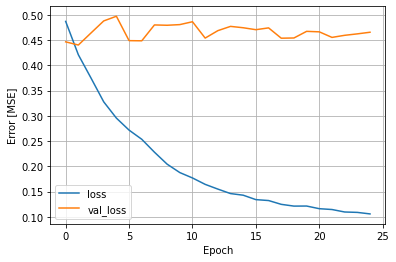

In [36]:
import matplotlib.pyplot as plt
plt.plot(deez_nuts.history['loss'], label='loss')
plt.plot(deez_nuts.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MSE]')
plt.legend()
plt.grid(True)

In [37]:
import json
json.dump(deez_nuts.history, open("deez_nuts.json", 'w'))